In [1]:
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
import os
import googlemaps
from pyproj import Geod
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime
from pyproj import Geod
from shapely.geometry import Point, LineString, Polygon

# Setting the working directory
if os.getcwd().endswith('notebook'):
    os.chdir(r'../')
print('Curremt working directory:', os.getcwd())

# Pandas option:
pd.set_option('max_colwidth',40)  # This allows us to see the data upto 40 characters per each column

pd.options.display.max_columns = None   # This allows us to see all the columns without collapsing 

# The below code is for for showing all expressions, not just the result of the last expression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Table styles, this below code is for decorating the dataframe no functional use.
table_styles = {
        'cerulean_palette' : [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80"), ("text-transform", "capitalize")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")])
    ]
}

# Filtering all the warnings:
warnings.filterwarnings('ignore')

Curremt working directory: /Users/howechen/Project/ntu_sd6101/ntu_sd6101_team_project


In [2]:
with open(r'../my api token/googlemaps.txt', 'r') as f:
    api_token = f.read()
    f.close()
gmaps = googlemaps.Client(key=api_token)

In [3]:
df = pd.read_csv(r'../ntu_sd6101_team_project_data/zomato.csv', na_values=['-','',' ','NEW','[]'])
drop_df = df.dropna(subset=['location'])
locations = pd.unique(drop_df['location']).tolist()
location_ids = range(1, len(locations)+1)
location_ids = [str(i).zfill(3) for i in location_ids]
location_id_map_dict = {
    str(i): str(j) for i,j in zip(locations, location_ids)
}
# df['location_id'] = df['location'].apply(lambda x: location_id_map_dict[str(x)])

In [5]:
location_df = pd.DataFrame({'location': locations, 'location_id': location_ids})

In [6]:
location_restaurant_counts = df['url'].groupby(df['location']).count().reset_index()
location_restaurant_counts.columns = ['location', 'restaurant_count']
location_df = pd.merge(location_df, location_restaurant_counts, on='location', how='left')
location_df

,location,location_id,restaurant_count
0,Banashankari,001,906
1,Basavanagudi,002,684
2,Mysore Road,003,22
3,Jayanagar,004,1926
4,Kumaraswamy Layout,005,195
...,...,...,...
89,West Bangalore,090,6
90,Magadi Road,091,34
91,Yelahanka,092,6
92,Sahakara Nagar,093,53


In [16]:
location_df['latitude'] = np.nan
location_df['longitude'] = np.nan
location_df['northeast_lat'] = np.nan
location_df['northeast_lng'] = np.nan
location_df['southwest_lat'] = np.nan
location_df['northeast_lng'] = np.nan
location_df

,location,location_id,restaurant_count,latitude,longitude,northeast_lat,northeast_lng,southwest_lat
0,Banashankari,001,906,NaN,NaN,NaN,NaN,NaN
1,Basavanagudi,002,684,NaN,NaN,NaN,NaN,NaN
2,Mysore Road,003,22,NaN,NaN,NaN,NaN,NaN
3,Jayanagar,004,1926,NaN,NaN,NaN,NaN,NaN
4,Kumaraswamy Layout,005,195,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
89,West Bangalore,090,6,NaN,NaN,NaN,NaN,NaN
90,Magadi Road,091,34,NaN,NaN,NaN,NaN,NaN
91,Yelahanka,092,6,NaN,NaN,NaN,NaN,NaN
92,Sahakara Nagar,093,53,NaN,NaN,NaN,NaN,NaN


In [11]:
def get_geoinfo(gmaps, address):
    if address == 'Others':
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        try:
            if address.split(',')[-1].strip() == 'India':
                address = address
            else:
                address = address + ', Bangalore, India'
            # print(address)
            geocode_result = gmaps.geocode(address)
            try:
                lat = geocode_result[0]['geometry']['location']['lat']
                lng = geocode_result[0]['geometry']['location']['lng']
                bounds = geocode_result[0]['geometry']['bounds']
                northeast = bounds['northeast']
                northeast_lat = northeast['lat']
                northeast_lng = northeast['lng']
                southwest = bounds['southwest']
                southwest_lat = southwest['lat']
                southwest_lng = southwest['lng']
            except KeyError:
                lat = geocode_result[0]['geometry']['location']['lat']
                lng = geocode_result[0]['geometry']['location']['lng']
                viewport = geocode_result[0]['geometry']['viewport']
                northeast_lat = viewport['northeast']['lat']
                northeast_lng = viewport['northeast']['lng']
                southwest_lat = viewport['southwest']['lat']
                southwest_lng = viewport['southwest']['lng']
            return lat, lng, southwest_lat, southwest_lng, northeast_lat, northeast_lng
        except Exception as e:
            print(f'Error: {e}')
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

In [17]:
location_df['latitude'], location_df['longitude'], location_df['southwest_lat'], location_df['southwest_lng'], location_df['northeast_lat'], location_df['northeast_lng'] = zip(*location_df['location'].apply(lambda x: get_geoinfo(gmaps, x)))

In [18]:
def compute_area(northeast_lat, northeast_lng, southwest_lat, southwest_lng):
    geod = Geod(ellps='WGS84')
    polygon = Polygon([
        (southwest_lng, southwest_lat),  # 西南角
        (southwest_lng, northeast_lat),  # 西北角
        (northeast_lng, northeast_lat),  # 东北角
        (northeast_lng, southwest_lat),   # 东南角
        (southwest_lng, southwest_lat)   # 闭合环，重复第一个点
    ])
    poly_area, _ = geod.geometry_area_perimeter(polygon)
    return abs(poly_area)

In [23]:
location_df['area'] = np.nan

In [24]:
for i in range(location_df.shape[0]):
    if location_df['location'][i] == 'Others':
        location_df.loc[i,'area'] = np.nan
    else:
        try:
            area = compute_area(location_df['northeast_lat'][i], location_df['northeast_lng'][i], location_df['southwest_lat'][i], location_df['southwest_lng'][i])
            location_df.loc[i,'area'] = area
        except Exception as e:
            print(f'Error: {i}')

In [26]:
location_df['area'].fillna(np.mean(location_df['area']), inplace=True)

In [27]:
location_df['area_proportion'] = location_df['area']/location_df['area'].sum()

In [28]:
location_df

,location,location_id,restaurant_count,latitude,longitude,northeast_lat,northeast_lng,southwest_lat,southwest_lng,area,area_proportion
0,Banashankari,001,906,12.925453,77.546757,12.956544,77.574414,12.912888,77.531272,2.260970e+07,0.002921
1,Basavanagudi,002,684,12.940600,77.573763,12.957252,77.580142,12.928614,77.561375,6.451724e+06,0.000833
2,Mysore Road,003,22,12.901548,77.468285,12.966943,77.587932,12.792788,77.379910,4.350043e+08,0.056195
3,Jayanagar,004,1926,12.930811,77.583858,12.946204,77.600701,12.912221,77.573609,1.105272e+07,0.001428
4,Kumaraswamy Layout,005,195,12.904438,77.564928,12.912197,77.573425,12.893798,77.552433,4.637250e+06,0.000599
...,...,...,...,...,...,...,...,...,...,...,...
89,West Bangalore,090,6,12.971599,77.594563,13.173706,77.882681,12.734289,77.379198,2.655736e+09,0.343078
90,Magadi Road,091,34,12.986927,77.476277,12.991974,77.564558,12.964547,77.378785,6.115682e+07,0.007900
91,Yelahanka,092,6,13.115466,77.606998,13.141923,77.617303,13.094701,77.580825,2.066397e+07,0.002669
92,Sahakara Nagar,093,53,13.062342,77.587103,13.077169,77.600632,13.055129,77.573844,7.083918e+06,0.000915


In [9]:
population_df = pd.read_csv(r'../ntu_sd6101_team_project_data/bangalore_population.csv')
population_df['Year'] = population_df['Year'].astype(int)
population_df = population_df[(population_df['Year']>=2011) & (population_df['Year']<=2022)]
population_df.reset_index(drop=True, inplace=True)
population_df['Population'] = population_df['Population']/10000
population_df

,Year,Population,Growth Rate
0,2022,1319.3,3.35%
1,2021,1276.5,3.55%
2,2020,1232.7,3.74%
3,2019,1188.3,3.87%
4,2018,1144.0,4.09%
5,2017,1099.0,4.10%
6,2016,1055.7,4.10%
7,2015,1014.1,4.10%
8,2014,974.2,4.10%
9,2013,935.8,4.09%


<Axes: xlabel='Year', ylabel='Population'>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Population (in 10,000)')

Text(0.5, 1.0, 'Bangalore Population Trend')

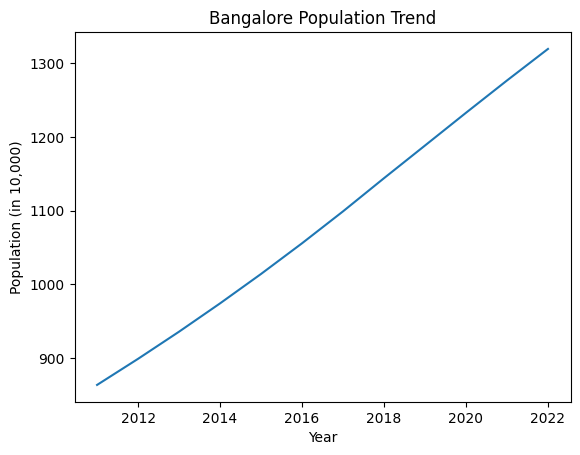

In [12]:
sns.lineplot(x='Year', y='Population', data=population_df)
plt.xlabel('Year')
plt.ylabel('Population (in 10,000)')
plt.title('Bangalore Population Trend')

In [14]:
visitors_df = pd.read_csv(r'../ntu_sd6101_team_project_data/bangalore_visitors.csv')
visitors_df['Year'] = visitors_df['Year'].astype(int)
visitors_df['Foreign Visitors'] = visitors_df['Foreign Visitors']/10000
visitors_df['Local Visitors'] = visitors_df['Local Visitors']/10000
visitors_df

,Year,Local Visitors,Foreign Visitors
0,2011,8410.7390,57.4005
1,2012,9405.2729,59.5359
2,2013,9801.0140,63.6378
3,2014,11828.3220,56.1970
4,2015,11986.3942,63.6502
5,2016,12976.2600,46.1752
6,2017,17998.0191,49.8148
7,2018,21430.6456,54.3716
8,2019,22793.4714,60.8754
9,2020,7745.3339,16.5325


<Axes: xlabel='Year', ylabel='Local Visitors'>

<Axes: xlabel='Year', ylabel='Local Visitors'>

Text(0, 0.5, 'Visitors (in 10,000)')

Text(0.5, 1.0, 'Bangalore Visitors Trend')

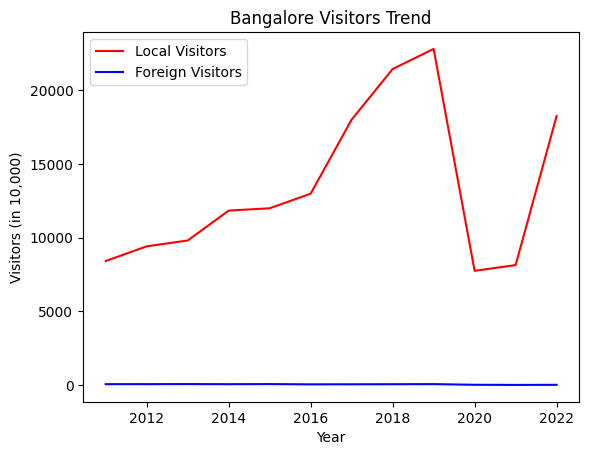

In [17]:
sns.lineplot(x='Year', y='Local Visitors', data=visitors_df, color='red', label='Local Visitors')
sns.lineplot(x='Year', y='Foreign Visitors', data=visitors_df, color='blue', label='Foreign Visitors')
plt.legend()
plt.ylabel('Visitors (in 10,000)')
plt.title('Bangalore Visitors Trend')

In [31]:
# local_tourists = 38014015/365
local_tourists = visitors_df['Local Visitors'].mean()/365   # daily average local tourists
foreign_tourists = visitors_df['Foreign Visitors'].mean()/365   # daily average foreign tourists
local_residents = population_df['Population'].mean()*0.066  # 6.6% of the population choose to eat out
area_population = local_residents + foreign_tourists + local_tourists

location_df['area_population'] = area_population
location_df['area_customer_flow'] = location_df['area_proportion']*location_df['area_population']

In [32]:
location_df[['area_population', 'area_customer_flow']] = location_df[['area_population', 'area_customer_flow']].applymap(lambda x: round(x, 4))

In [33]:
location_df

,location,location_id,restaurant_count,latitude,longitude,northeast_lat,northeast_lng,southwest_lat,southwest_lng,area,area_proportion,area_population,area_customer_flow
0,Banashankari,001,906,12.925453,77.546757,12.956544,77.574414,12.912888,77.531272,2.260970e+07,0.002921,1.083382e+06,3164.3497
1,Basavanagudi,002,684,12.940600,77.573763,12.957252,77.580142,12.928614,77.561375,6.451724e+06,0.000833,1.083382e+06,902.9537
2,Mysore Road,003,22,12.901548,77.468285,12.966943,77.587932,12.792788,77.379910,4.350043e+08,0.056195,1.083382e+06,60881.1999
3,Jayanagar,004,1926,12.930811,77.583858,12.946204,77.600701,12.912221,77.573609,1.105272e+07,0.001428,1.083382e+06,1546.8883
4,Kumaraswamy Layout,005,195,12.904438,77.564928,12.912197,77.573425,12.893798,77.552433,4.637250e+06,0.000599,1.083382e+06,649.0082
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,West Bangalore,090,6,12.971599,77.594563,13.173706,77.882681,12.734289,77.379198,2.655736e+09,0.343078,1.083382e+06,371684.6045
90,Magadi Road,091,34,12.986927,77.476277,12.991974,77.564558,12.964547,77.378785,6.115682e+07,0.007900,1.083382e+06,8559.2281
91,Yelahanka,092,6,13.115466,77.606998,13.141923,77.617303,13.094701,77.580825,2.066397e+07,0.002669,1.083382e+06,2892.0348
92,Sahakara Nagar,093,53,13.062342,77.587103,13.077169,77.600632,13.055129,77.573844,7.083918e+06,0.000915,1.083382e+06,991.4326


In [34]:
location_df.to_csv(r'../ntu_sd6101_team_project_data/location_info.csv', index=False)